In [1]:
# standard libs
import string
from functools import reduce
from collections import Counter

# data manipulation
import pandas as pd

# data viz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# text processing
import spacy
from wordcloud import WordCloud

In [2]:
%%bash
TMPLOG=$(pwd)/tmp-project-log.csv
echo "project,timestamp,message" > $TMPLOG
curdir=$(pwd)
cd ..
for i in *
do
   if [ -d $i ] && [ -d $i/.git ]
   then
      cd $i
      git log --since='1 year ago' --author="$(git config --get user.name)" --pretty=format:"$i,%ai,\"%s\"" >> $TMPLOG
      echo "" >> $TMPLOG
      cd ..
   fi
done
cd $curdir
grep . $TMPLOG > project-logs.csv
rm $TMPLOG

In [3]:
commit_df = pd.read_csv('project-logs.csv',
                        index_col=1,
                        parse_dates=True)
commit_df['c_date'] = [d.strftime("%Y-%m-%d") for d in commit_df.index.date]
commit_df['c_time'] = [d.strftime("%H:%M:%S") for d in commit_df.index.time]

repo_commit_count = commit_df.groupby('project')[['project']].agg('count')
top_20_repos = repo_commit_count.nlargest(20, 'project')
top_10_repos = repo_commit_count.nlargest(10, 'project')

top_20_commit_df = commit_df[commit_df['project'].isin(top_20_repos.index)]

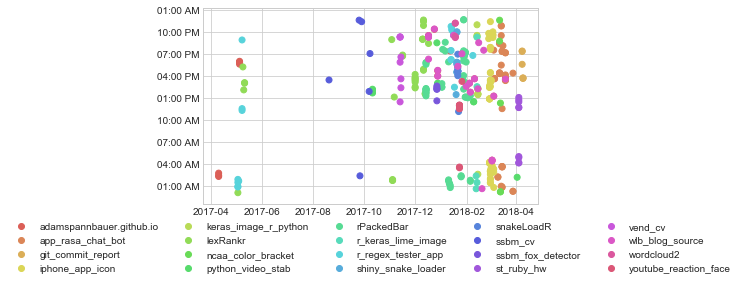

In [4]:
sns.set_style("whitegrid")
# create color pallete map to project labels
color_labels = top_20_commit_df.project.unique()
rgb_values = sns.color_palette("hls", len(color_labels))
color_map = dict(zip(color_labels, rgb_values))

# generate date and time axes
x_date = mdates.datestr2num(top_20_commit_df.c_date)
y_time = mdates.datestr2num(top_20_commit_df.c_time)

# create figure
fig, ax = plt.subplots()

# plot scatter colored by project
ax.scatter(x_date, y_time, c=top_20_commit_df['project'].map(color_map))
ax.yaxis_date()
ax.xaxis_date()

# convert y axis labels to show hour:minute
yfmt = mdates.DateFormatter('%I:%M %p')
ax.yaxis.set_major_formatter(yfmt)

# create legend entries
markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in color_map.values()]
plt.legend(markers, color_map.keys(), numpoints=1)

# put legend under plot
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(markers,
          color_map.keys(),
          numpoints=1,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.05),
          ncol=5)

plt.show()

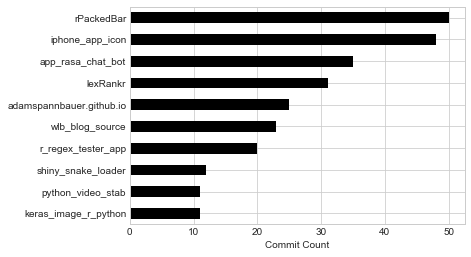

In [5]:
top_10_repos.columns = ['count']
top_10_repos.sort_values('count', ascending=True, inplace=True)
top_10_repos.reset_index().plot(x='project', 
                                y='count', 
                                kind='barh', 
                                color='black',
                                legend=None)
plt.xlabel('Commit Count')
plt.ylabel('')

plt.show()

In [6]:
nlp = spacy.load('en')
commits = [nlp(c) for c in commit_df['message']]
lemmas = [[w.lemma_ for w in c if not w.is_stop] for c in commits]
lemmas = reduce(lambda x, y: x+y, lemmas)
punc = string.punctuation
lemmas = [w for w in lemmas if not '' == ''.join(c for c in w if c not in punc)]
lemmas = [w for w in lemmas if len(w) <= 20]
lemma_counts = Counter(lemmas)

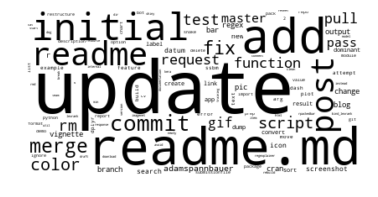

In [7]:
def black_color_func(word, font_size, position, orientation, random_state=None,
                     **kwargs):
    return "hsl(0, 0%, 0%)"


wc = WordCloud(background_color="white", color_func=black_color_func)
wc.generate_from_frequencies(lemma_counts)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

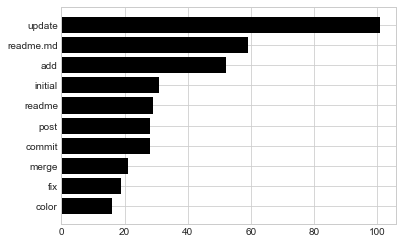

In [8]:
top_10_lemmas = dict(lemma_counts.most_common(10))

plt.barh(range(len(top_10_lemmas)), 
         list(top_10_lemmas.values())[::-1], 
         align='center',
         color='black')
plt.yticks(range(len(top_10_lemmas)), list(top_10_lemmas.keys())[::-1])

plt.show()